# Outliers or Anomaly Detection is a crucial pre-processing step as significant outliers can influence the result of a model

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# set display options
pd.set_option('display.max_columns', 50)
pd.options.display.min_rows = 50
pd.options.display.precision = 2

In [2]:
# set plot size
plt.rcParams['figure.figsize'] = (9,6)

In [3]:
# read the file
df = pd.read_csv("Superstore Sales Dataset.csv", parse_dates=['Order Date','Ship Date'], dayfirst=True)

In [4]:
# have a look at the 1st 5 rows of the dataset
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
1       2  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
2       3  CA-2017-138688 2017-06-12 2017-06-16    Second Class    DV-13045   
3       4  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   
4       5  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name   Sales  
0                  Bush Somerset Collection Bookcase  261.96  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94  
2  Self-Adhesive Address Labels for Typewriters b...   14.62  
3      Bretford CR4500 Series Slim Rectangular Table  957.58  
4                     Eldon Fold 'N Roll Cart System   22.37

In [5]:
# make a copy of the df for further processing while keeping the orignal dataset intact as a backup
df1 = df.copy()

In [6]:
# perform eda with pandas profiling to have a better understanding of the dataset
import ydata_profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df1, title="Pandas Profiling Report")

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# make a new dataset with only ship dates and sales for outlier detection
df2 = df1[['Ship Date','Sales']]
df2.head()

Ship Date   Sales
0 2017-11-11  261.96
1 2017-11-11  731.94
2 2017-06-16   14.62
3 2016-10-18  957.58
4 2016-10-18   22.37

In [8]:
# set ship date as index
df2.set_index('Ship Date', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2017-11-11 to 2016-01-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   9800 non-null   float64
dtypes: float64(1)
memory usage: 153.1 KB


In [9]:
# as there are more than 1 sales for a particular day, combine all sales for a day through re-sampling 
df2 = df2.resample(rule='D').sum()
df2.head()

Sales
Ship Date          
2015-01-07    29.23
2015-01-08   307.50
2015-01-09     0.00
2015-01-10  4374.88
2015-01-11     0.00

In [10]:
# let's have a look the resmapled dataset and there should be a reduction in the number of rows (i.e. from 9800)
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1460 entries, 2015-01-07 to 2019-01-05
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   1460 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [11]:
# check whether there are missing dates in the date range.  If there is no missing dates, the DF info will be returned
start = df2.index.min()
end = df2.index.max()

print(pd.date_range(start=start, end=end).difference(df2.index))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## Checking for Outliers / Anomaly Detection

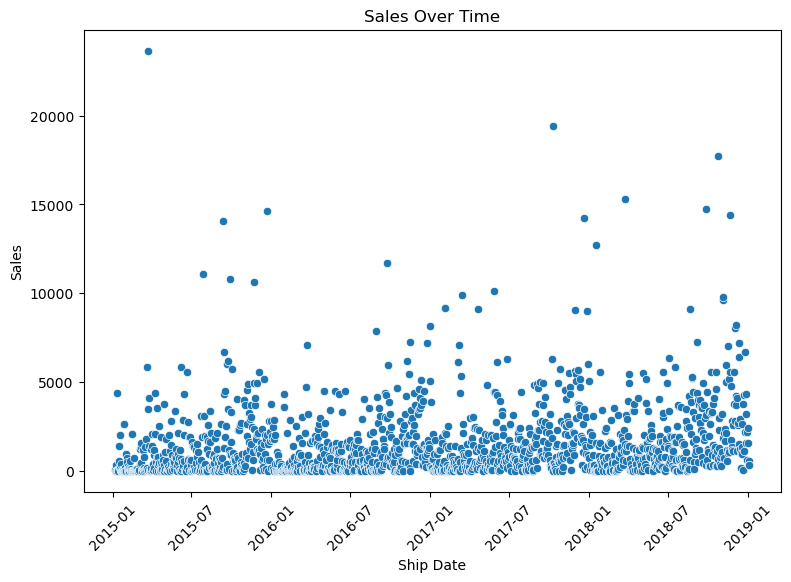

In [12]:
# visually by ploting a scatterplot
%matplotlib inline

sns.scatterplot(df2, x=df2.index, y='Sales')
plt.title("Sales Over Time")
plt.xticks(rotation=45)
plt.show()

As noted in the above scatterplot, there are some outliers (i.e. not within the usual concentration of values)

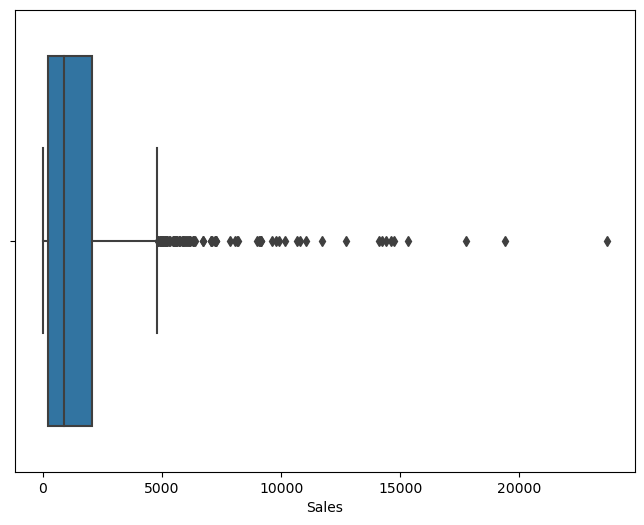

In [13]:
# we can also use a boxplot for visualization
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x=df2['Sales'])
plt.show()

As noted the in the boxplot there are values above the 3rd Quantile of dataset

In [14]:
# let's locate the outliers using Inter Quantile Range method (i.e. a numerical representation of the above boxplot)
Q1 = df2['Sales'].quantile(0.25)
Q3 = df2['Sales'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_range = df2[(df2['Sales'] < lower_bound) | (df2['Sales'] > upper_bound)]
outliers_range['Sales'].sort_values(ascending=False)

Ship Date
2015-03-23    23661.23
2017-10-09    19413.71
2018-10-24    17753.49
2018-03-25    15335.81
2018-09-26    14751.74
2015-12-21    14605.96
2018-11-22    14415.07
2017-12-21    14243.34
2015-09-12    14083.06
2018-01-18    12703.30
2016-09-23    11709.59
2015-07-27    11056.41
2015-09-28    10798.54
2015-11-22    10657.31
2017-05-27    10143.14
2017-03-15     9926.07
2018-11-05     9796.07
2018-11-04     9628.08
2017-02-04     9151.20
2017-04-20     9135.19
2018-08-22     9089.97
2017-11-30     9066.95
2017-12-28     8996.36
2018-12-06     8190.15
2016-12-30     8133.35
                ...   
2016-11-12     5459.76
2017-03-13     5335.00
2018-08-26     5282.94
2018-08-25     5216.39
2018-11-18     5188.42
2015-12-14     5186.85
2017-12-12     5156.00
2018-05-11     5139.30
2016-12-10     5128.81
2017-12-02     5080.44
2016-12-31     5041.34
2017-12-31     5040.30
2018-11-13     5014.57
2017-09-10     4985.50
2015-11-23     4963.15
2015-11-29     4959.36
2017-10-21     4954.89
2

There are 92 values that are considered outliers using IQR analysis 

In [15]:
# convert to a DF
outliers_range = pd.DataFrame(outliers_range)
outliers_range.sample(5)

Sales
Ship Date          
2018-11-05  9796.07
2015-09-23  6171.34
2017-10-26  5753.81
2018-05-11  5139.30
2016-11-08  6186.89

In [16]:
# outlier detection using Isolation Forest
from sklearn.ensemble import IsolationForest

contamination = 0.01

clf = IsolationForest(contamination=contamination, random_state=42)
clf.fit(df2)

IsolationForest(contamination=0.01, random_state=42)

In [17]:
# # outlier detection using Local Outlier Factor method

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination = contamination, novelty=True)
lof.fit(df2)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [18]:
# create a new column to store the predicted value of the Isolation Forest
df2['anomaly_isoforest'] = clf.predict(df2)
df2['anomaly_isoforest'].value_counts()

 1    1445
-1      15
Name: anomaly_isoforest, dtype: int64

In [19]:
df2[(df2['anomaly_isoforest'] == -1) ]

Sales  anomaly_isoforest
Ship Date                              
2015-03-23  23661.23                 -1
2015-07-27  11056.41                 -1
2015-09-12  14083.06                 -1
2015-09-28  10798.54                 -1
2015-11-22  10657.31                 -1
2015-12-21  14605.96                 -1
2016-09-23  11709.59                 -1
2017-05-27  10143.14                 -1
2017-10-09  19413.71                 -1
2017-12-21  14243.34                 -1
2018-01-18  12703.30                 -1
2018-03-25  15335.81                 -1
2018-09-26  14751.74                 -1
2018-10-24  17753.49                 -1
2018-11-22  14415.07                 -1

In [26]:
# visualize using the Anomaly Detection Tool Kit 
!pip install adtk

In [20]:
# make a copy of dataset for further processing
df2_1 = df2.copy()
df2_1.head()

Sales  anomaly_isoforest
Ship Date                             
2015-01-07    29.23                  1
2015-01-08   307.50                  1
2015-01-09     0.00                  1
2015-01-10  4374.88                  1
2015-01-11     0.00                  1

In [21]:
df2_1.drop(columns = ['anomaly_isoforest'], axis=1, inplace=True)
df2_1.head()

Sales
Ship Date          
2015-01-07    29.23
2015-01-08   307.50
2015-01-09     0.00
2015-01-10  4374.88
2015-01-11     0.00

In [22]:
# validate the series...if there are any issues, these will be flagged
from adtk.data import validate_series
df2_1 = validate_series(df2_1)

[<Axes: >]

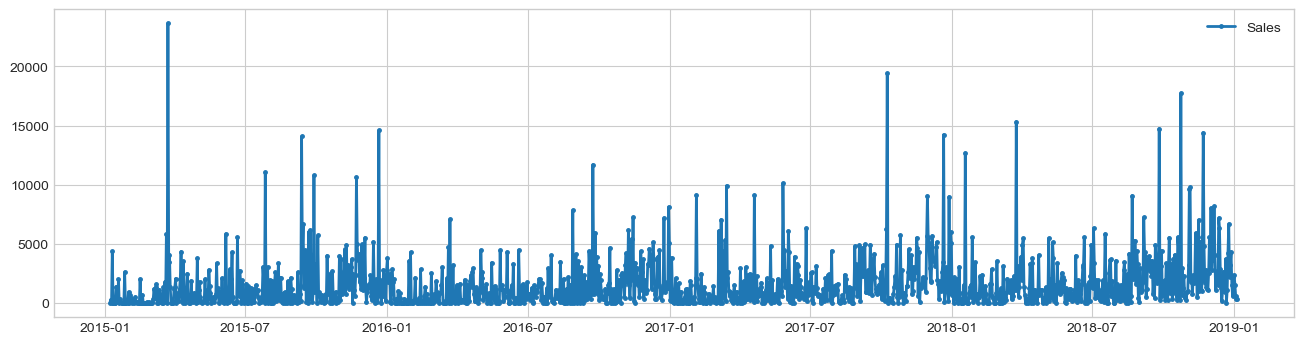

In [23]:
# plot the time series
from adtk.visualization import plot
plot(df2_1, ts_linewidth=2, ts_markersize=5)

(array([1.152e+03, 2.150e+02, 6.200e+01, 1.300e+01, 8.000e+00, 2.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([    0.    ,  2366.1228,  4732.2456,  7098.3684,  9464.4912,
        11830.614 , 14196.7368, 16562.8596, 18928.9824, 21295.1052,
        23661.228 ]),
 <BarContainer object of 10 artists>)

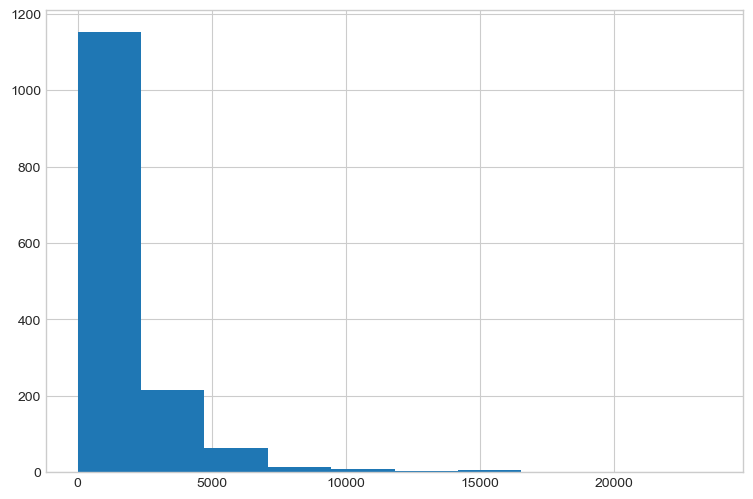

In [24]:
# plotting a histogram
plt.hist(df2_1, bins=10)

In [25]:
# identify outliers based on domain knowledge (i.e. what's the range of customer spend based on experience / historical data).  
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high=5000, low=0)
anomalies = threshold_ad.detect(df2_1)

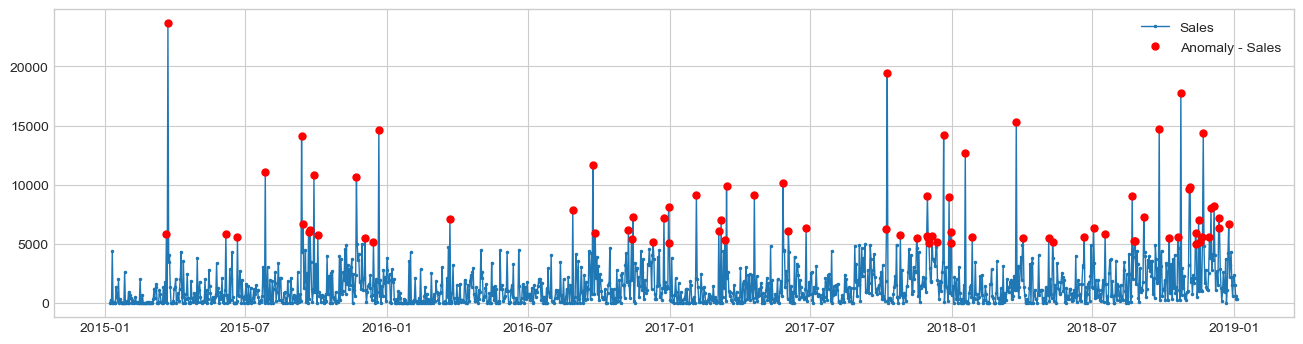

In [26]:
# plot the results for better visualization
from adtk.visualization import plot
plot(df2_1, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

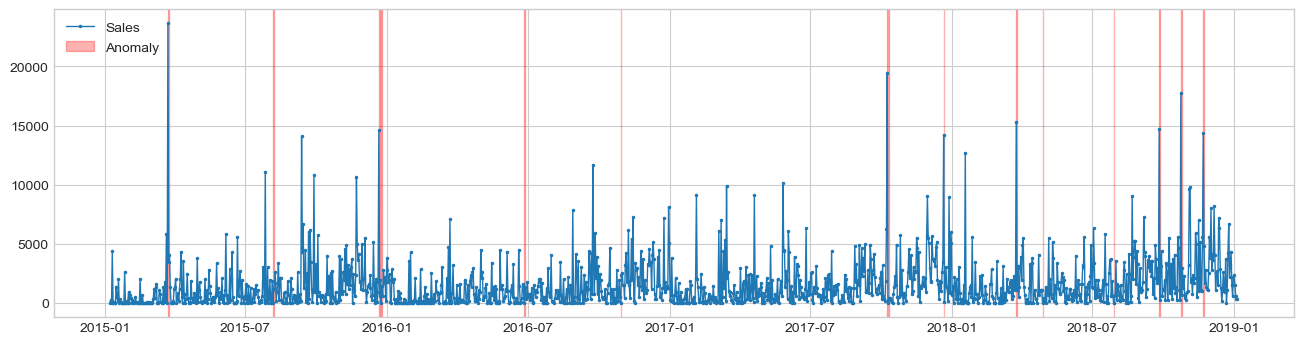

In [27]:
# using LocalOutlierFactor to disover anomaly
from adtk.detector import OutlierDetector
from adtk.visualization import plot

from sklearn.neighbors import LocalOutlierFactor

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df2_1)
plot(df2_1, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [28]:
# understanding what are the anomalies detected
df2_1['anomaly_adtk'] = anomalies
df2_1[(df2_1['anomaly_adtk'] == True)]

Sales  anomaly_adtk
Ship Date                         
2015-03-23  23661.23          True
2015-08-06      5.68          True
2015-12-21  14605.96          True
2015-12-24      5.48          True
2016-06-26      4.96          True
2016-10-29      3.59          True
2017-10-09  19413.71          True
2017-10-10      4.93          True
2017-12-21  14243.34          True
2018-03-25  15335.81          True
2018-04-28      1.81          True
2018-07-29      3.30          True
2018-09-26  14751.74          True
2018-10-24  17753.49          True
2018-11-22  14415.07          True

In [29]:
# revert to orignal df2_1
df2_1.drop(columns = ['anomaly_adtk'], axis = 1, inplace=True)

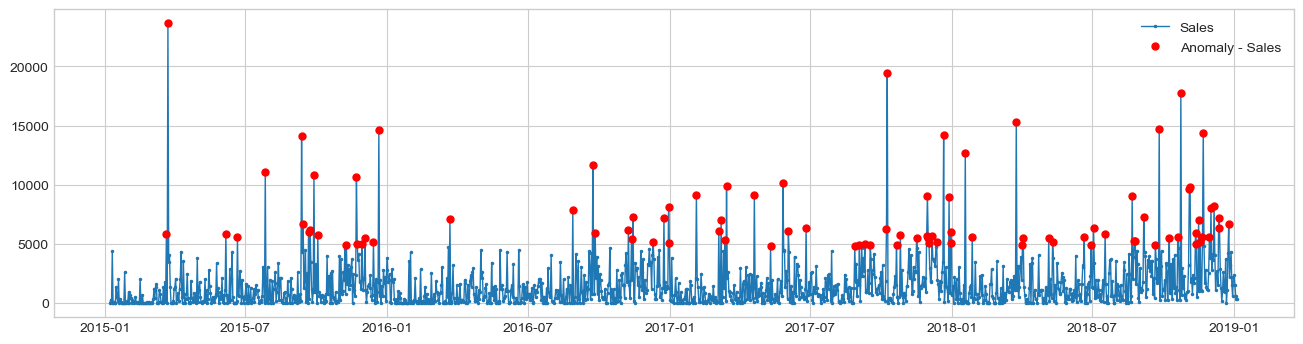

In [30]:
# using IQR as a detection method
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(df2_1)

plot(df2_1, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");


In [31]:
# understanding the anomalies from IQR
df2_1['anomaly_adtk'] = anomalies
df2_1[(df2_1['anomaly_adtk'] == True)]

Sales  anomaly_adtk
Ship Date                         
2015-03-21   5819.64          True
2015-03-23  23661.23          True
2015-06-06   5864.36          True
2015-06-21   5564.00          True
2015-07-27  11056.41          True
2015-09-12  14083.06          True
2015-09-14   6706.71          True
2015-09-21   6029.56          True
2015-09-23   6171.34          True
2015-09-28  10798.54          True
2015-10-03   5727.08          True
2015-11-09   4907.77          True
2015-11-22  10657.31          True
2015-11-23   4963.15          True
2015-11-29   4959.36          True
2015-12-03   5538.00          True
2015-12-14   5186.85          True
2015-12-21  14605.96          True
2016-03-22   7089.27          True
2016-08-28   7860.65          True
2016-09-23  11709.59          True
2016-09-26   5953.95          True
2016-11-08   6186.89          True
2016-11-12   5459.76          True
2016-11-14   7251.26          True
...              ...           ...
2018-07-03   6350.87          True
2018-07-18   5859.07          True
2018-08-22   9089.97          True
2018-08-25   5216.39          True
2018-08-26   5282.94          True
2018-09-06   7241.43          True
2018-09-21   4928.07          True
2018-09-26  14751.74          True
2018-10-09   5542.61          True
2018-10-20   5585.63          True
2018-10-24  17753.49          True
2018-11-04   9628.08          True
2018-11-05   9796.07          True
2018-11-12   5937.57          True
2018-11-13   5014.57          True
2018-11-16   7040.76          True
2018-11-18   5188.42          True
2018-11-21   5570.95          True
2018-11-22  14415.07          True
2018-11-30   5556.32          True
2018-12-02   8048.54          True
2018-12-06   8190.15          True
2018-12-12   7201.93          True
2018-12-13   6388.03          True
2018-12-25   6696.64          True

[92 rows x 2 columns]

Great that the results are the same as that we computed manually above!!!